## Astronomy 406 "Computational Astrophysics" (Fall 2017)

### Week 7: Confidence limits, Drawing from a distribution, Parametric bootstrap

<b>Reading:</b> notes below, as well as $\S$[15.6](https://umich.instructure.com/files/2682016/download?download_frd=1) and [7.3](https://umich.instructure.com/files/2832366/download?download_frd=1) of [Numerical Recipes](http://numerical.recipes), and $\S$3.7, 4.2-4.3, 4.5, 8.2, and 8.8 of [Machine Learning](http://www.astroml.org/)</a>.

In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 90
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, interpolate, stats, special
np.random.seed(0)

In Week 6 notebook we have derived the maximum likelihood for linear regression with instrinsic scatter:

$y = f(x | a,b,\sigma) = a + b x + \epsilon$,

where the scatter of each data point $\epsilon_i$ is described by a normal distribution $N(0,\sigma)$.  Omitting a normalization constant, the log-likelihood is

$2\ln{\cal L} = -\sum_i \ln{\sigma_i^2} - \sum_i {(y_i - a - b x_i)^2 / \sigma_i^2}$,

with $\sigma_i^2 \equiv \sigma_{y,i}^2 + b^2 \sigma_{x,i}^2 + \sigma^2$.

The intercept value $a$ can be calculated analytically as 
$a = {\sum_i w_i (y_i - b x_i) / \sum_i w_i}$, with $w_i \equiv \sigma_{i}^{-2}$.

Using the weights $w_i$, the function to be minimized can be written concisely as

$-2\ln{\cal L} = -\sum_i \ln{w_i} + \sum_i w_i (y_i - a - b x_i)^2$.

### Bootstrap

What do estimated errors of the best-fit parameters mean?  Do they obey a Gaussian statistic with mean $a$ and standard deviation $da$?  Or do they obey a different distribution, and how can we know that?  These questions are the reason to try to understand the whole distribution of the model parameters.

One of the simplest, and yet accurate and effective, ways of estimating the parameter distribution is <b>bootstrap</b>.  In this method we create many new datasets based on the original dataset, and derive the best-fit parameters for all of them, thus creating a distribution of the parameter values.  The trick is to have the new datasets to obey the same distribution function as the original sample.  This is achieved by drawing data points from the original dataset $x_i, y_i$, with repetition.

The simplest way to draw a bootstrap sample is to generate a new array of indices $j$, composed of random integers from 0 to $N-1$. Then the new data set is simply $x_j, y_j$.  The phrase "with repetition" means that some data points may appear in the new dataset multiple times, while some others will disappear.

<b>Exercise:</b> Re-write the $2\ln{\cal L}$ function to take additional arguments for the bootstrapped sample ($x,y,dx,dy$).  Write additional function that evaluates the intercept given the parameter array $p$ and the bootstrapped sample.

In [2]:
def lnLikelihood( p, xb, yb, dxb, dyb ):
    b = p[0]
    sig = p[1]    
    w = 1./(sig**2 + dyb**2 + (b*dxb)**2)
    a = np.sum(w*(yb-b*xb))/np.sum(w)
    return np.sum(-np.log(w) + w*(yb-a-b*xb)**2)

def intercept( p, xb, yb, dxb, dyb ):
    b = p[0]
    sig = p[1]    
    w = 1./(sig**2 + dyb**2 + (b*dxb)**2)
    a = np.sum(w*(yb-b*xb))/np.sum(w)
    return a

In [3]:
Lgal, dLgal, Mgc, dMgc = np.loadtxt('DataFiles/gc_galaxy.dat', unpack=True)

ind = (Lgal > 9) 
x = Lgal[ind]; dx = dLgal[ind]; y = Mgc[ind]; dy = dMgc[ind]

Let's choose a convergence criterion such that the parameter mean and std values vary by less than 0.1%, on the average.

In [4]:
def convergence_criterion(pmean, pstd, pmean_last, pstd_last):
    
    d = np.sum(abs((pmean-pmean_last)/pmean) + abs((pstd-pstd_last)/pstd))
    
    if d < 0.006:
        return False, d
    else:
        return True, d

Here is a simple example to run bootstrap realizations until the convergence criterion is satisfied.

In [5]:
#the actual bootstrap
nvar = 3
pboot = [[], [], []]
pmean = np.zeros(nvar)
pstd = np.zeros(nvar)
#converged = (pmean > 1)

iboot = 0
icheck = 100
inext = icheck
not_converged = True

while not_converged and iboot < 10000:
    
    iboot += 1
    ir = np.random.randint(low=0, high=len(x), size=len(x)) #set of random integrers from zero to N-1 of lenght n
    #print ir
    xb = x[ir]; yb = y[ir]; dxb = dx[ir]; dyb = dy[ir]
    
    o = optimize.minimize(lnLikelihood, [1.,1.], args=(xb, yb, dxb, dyb))
    
    #boot strapped parameters
    pboot[0].append(o.x[0])
    pboot[1].append(o.x[1])
    pboot[2].append(intercept(o.x, xb, yb, dxb, dyb))
    
    #caluclate statiscis of data
    if iboot >= inext:
        pmean_last = np.copy(pmean)
        pstd_last = np.copy(pstd)
        pmean = np.mean(pboot, axis=1)
        pstd = np.std(pboot, ddof=1, axis=1)
                  
        not_converged, d = convergence_criterion(pmean, pstd, pmean_last, pstd_last)
            
        print 'iboot = %4d d = %.4f a = %.4f +- %.4f b = %.4f +- %.4f sig2 = %.4f +- %.4f'\
            %(iboot, d, pmean[2], pstd[2], pmean[0], pstd[0], pmean[1], pstd[1])
        inext += icheck

iboot =  100 d = 6.0000 a = -6.6686 +- 0.3611 b = 1.4309 +- 0.0357 sig2 = 0.3580 +- 0.0746
iboot =  200 d = 0.4743 a = -6.6868 +- 0.3454 b = 1.4329 +- 0.0339 sig2 = 0.3620 +- 0.0548
iboot =  300 d = 0.3135 a = -6.7067 +- 0.3499 b = 1.4349 +- 0.0344 sig2 = 0.3573 +- 0.0750
iboot =  400 d = 0.0308 a = -6.7147 +- 0.3459 b = 1.4357 +- 0.0339 sig2 = 0.3574 +- 0.0748
iboot =  500 d = 0.1344 a = -6.7121 +- 0.3419 b = 1.4354 +- 0.0335 sig2 = 0.3592 +- 0.0676


C:\Users\Adam2\Anaconda\lib\site-packages\scipy\optimize\optimize.py:891: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


iboot =  600 d = 0.1929 a = -6.7221 +- 0.3463 b = 1.4364 +- 0.0339 sig2 = 0.3565 +- 0.0804
iboot =  700 d = 0.0275 a = -6.7151 +- 0.3434 b = 1.4358 +- 0.0337 sig2 = 0.3577 +- 0.0798
iboot =  800 d = 0.0894 a = -6.7161 +- 0.3475 b = 1.4359 +- 0.0341 sig2 = 0.3584 +- 0.0751
iboot =  900 d = 0.0633 a = -6.7139 +- 0.3500 b = 1.4357 +- 0.0343 sig2 = 0.3574 +- 0.0788
iboot = 1000 d = 0.0721 a = -6.7128 +- 0.3464 b = 1.4355 +- 0.0339 sig2 = 0.3580 +- 0.0751
iboot = 1100 d = 0.0513 a = -6.7125 +- 0.3472 b = 1.4355 +- 0.0340 sig2 = 0.3586 +- 0.0719
iboot = 1200 d = 0.1262 a = -6.7123 +- 0.3500 b = 1.4355 +- 0.0343 sig2 = 0.3567 +- 0.0803
iboot = 1300 d = 0.0330 a = -6.7146 +- 0.3513 b = 1.4357 +- 0.0344 sig2 = 0.3562 +- 0.0823
iboot = 1400 d = 0.0451 a = -6.7128 +- 0.3501 b = 1.4355 +- 0.0343 sig2 = 0.3570 +- 0.0795
iboot = 1500 d = 0.0160 a = -6.7161 +- 0.3480 b = 1.4358 +- 0.0341 sig2 = 0.3569 +- 0.0792
iboot = 1600 d = 0.0424 a = -6.7169 +- 0.3461 b = 1.4359 +- 0.0338 sig2 = 0.3570 +- 0.0769

Compare these values with the original fit:

In [6]:
o = optimize.minimize(lnLikelihood, [1.,1.], args=(x, y, dx, dy))
    
b = o.x[0]
sig2 = o.x[1]
a = intercept(o.x, x, y, dx, dy)
db = np.sqrt(o.hess_inv[0,0])
dsig = np.sqrt(o.hess_inv[1,1])
                      
print 'a = %.4f +- %.4f  b = %.4f +- %.4f  sig2 = %.4f +- %.4f' % (a, 0, b, db, sig2, dsig)

a = -6.7106 +- 0.0000  b = 1.4353 +- 0.0150  sig2 = 0.3669 +- 0.0138


The mean values are slightly different but consistent within the errors. More importantly, the standard deviations in the bootstrap are larger. They include the covariances of the parameters. 

We should take only the std values from bootstrap. The best parameters values should still determined by the original dataset.

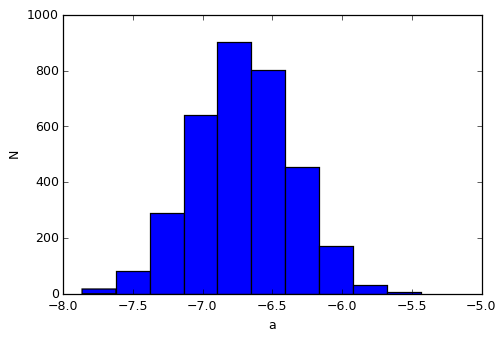

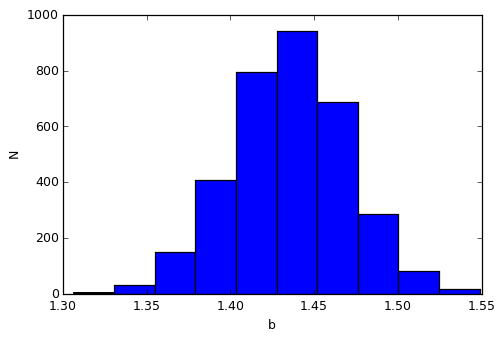

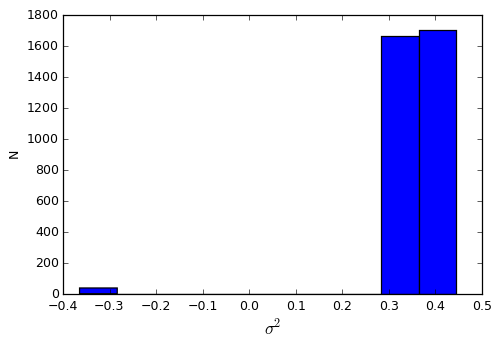

In [7]:
plt.xlabel('a')
plt.ylabel('N')
plt.hist(pboot[2])
plt.show()

plt.xlabel('b')
plt.ylabel('N')
plt.hist(pboot[0])
plt.show()

plt.xlabel('$\sigma^2$', size=14)
plt.ylabel('N')
plt.hist(pboot[1])
plt.show()

In [8]:
f = open('bootstrap.dat', 'w')
for bb, ss, aa in zip(pboot[0], pboot[1], pboot[2]):
    f.write('%.4f %.4f %.4f\n'%(bb, ss, aa))
f.close()

Let's now plot the range of models allowed by the best-fit parameters and their errors.

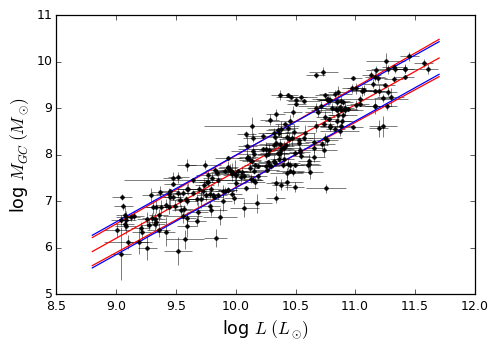

In [9]:
xa = np.linspace(8.8, 11.7)
plt.plot(xa, a + b*xa, 'r-')             #original
plt.plot(xa, a + (b+pstd[0])*xa, 'r-')   #change of slope
plt.plot(xa, a + (b-pstd[0])*xa, 'r-')
plt.plot(xa, a+pstd[2] + b*xa, 'b-')    #change of intercept
plt.plot(xa, a-pstd[2] + b*xa, 'b-')

plt.errorbar(x, y, xerr=dx, yerr=dy, fmt='.k', elinewidth=0.4, capsize=0)
plt.xlabel(r'log $L \ (L_\odot)$', size=14)
plt.ylabel(r'log $M_{GC} \ (M_\odot)$', size=14)
plt.show()

### Confidence limits

Bootstrap gives us the distributions of each of the model parameters.  We can use them to set confidence limits on the derived best-fit parameters.

<b>Exercise:</b> Write a routine to calculate the range containing a given percentage of the bootstrap distribution, for each of the model parameters.  For example, return $da$ such that 90% (should be free parameter) of the values of $a$ are within $a \pm da$.

Having bootstrap distributions also allows us to investigate the relations between the best-fit parameters.  For example, there is a strong anti-correlation of $a$ and $b$:

In [10]:
def confidence(p,clim):
    dpi=np.abs(p-np.mean(p))
    arr=np.sort(dpi)
    N=len(p)
    
    #print np.mean(p)+dpi[int(N*clim)]
    #print np.mean(p)-dpi[int(N*clim)]
    return (np.mean(p)+dpi[int(N*clim)])-(np.mean(p)-dpi[int(N*clim)])
    
print confidence(pboot[0],.683)
print np.std(pboot[0])

print confidence(pboot[1],.683)
print np.std(pboot[1])

print confidence(pboot[2],.683)
print np.std(pboot[2])

0.0728707289436
0.0342925292384
0.000584297612514
0.0775282750405
0.781236316053
0.350717551274


In [11]:
# new modules that will be needed here
from matplotlib.patches import Ellipse
from astroML.stats import fit_bivariate_normal

# read saved bootstrap realization
bb, ss, aa = np.loadtxt("bootstrap.dat", unpack=True)

Boot: a = -6.7108 +- 0.3507  b = 1.4352 +- 0.0343  sig = 0.3566 +- 0.0775


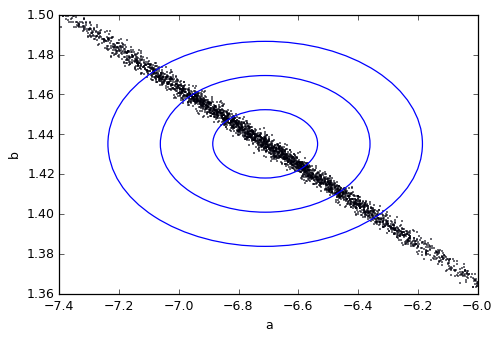

In [12]:
plt.xlim(-7.4, -6)
plt.ylim(1.36, 1.5)
plt.xlabel('a')
plt.ylabel('b')
plt.scatter(aa, bb, s=0.2)

mean = [np.mean(aa), np.mean(bb)]
sigma1 = np.std(aa)
sigma2 = np.std(bb)

print 'Boot: a = %.4f +- %.4f  b = %.4f +- %.4f  sig = %.4f +- %.4f' %\
  (np.mean(aa), np.std(aa), np.mean(bb), np.std(bb), np.mean(ss), np.std(ss))
    
for Nsig in (1, 2, 3):    
    plt.gca().add_patch(\
    Ellipse(mean, Nsig*sigma1, Nsig*sigma2, angle=0, ec='b', fc='none'))

The blue contours enclose the expected $1\sigma$, $2\sigma$, and $3\sigma$ distribution of the parameters, in the absence of their correlation.  Clearly, they do not correspond to the actual distribution.

An alternative method, suggested by <a href="http://arxiv.org/abs/1008.4686">Hogg et al.</a>, effectively rotates the coordinate system to align with the correlation and fits the ellipses along and perpendicular to it.  The resulting contours are much tighter!

Corr: sigma1 = 0.3524  sigma2 = 0.0023  angle = -0.0972
Corr: a = -6.7108 +- 0.3505  b = 1.4352 +- 0.0365


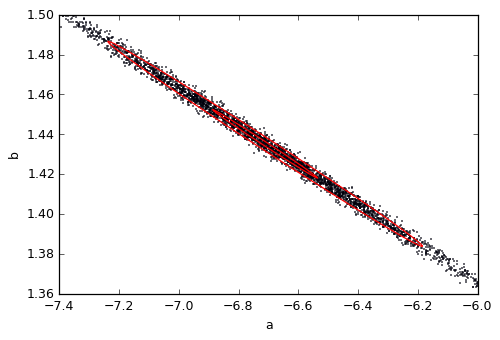

In [13]:
plt.xlim(-7.4, -6)
plt.ylim(1.36, 1.5)
plt.xlabel('a')
plt.ylabel('b')
plt.scatter(aa, bb, s=0.2)

mean, sigma1, sigma2, alpha = fit_bivariate_normal(aa, bb, robust=False)

da = sigma1*np.cos(alpha) + sigma2*np.sin(alpha)
db = -sigma1*np.sin(alpha) + sigma2*np.cos(alpha)

print 'Corr: sigma1 = %.4f  sigma2 = %.4f  angle = %.4f' % (sigma1, sigma2, alpha)
print 'Corr: a = %.4f +- %.4f  b = %.4f +- %.4f' % (mean[0], da, mean[1], db)

for Nsig in (1, 3):
    plt.gca().add_patch(\
    Ellipse(mean, Nsig*sigma1, Nsig*sigma2, angle=alpha*180./np.pi, ec='r', fc='none'))

This method does not depend on whether we fit $x$ vs. $y$, or $y$ vs. $x$.  We will see below that it is a very useful property.  However, it has a potential pitfall in the interpretation of dispersions $\sigma_1$ and $\sigma_2$ when the variables $a$ and $b$ have different units.

There is another solution.  The correlation of $a$ and $b$ arises because the pivot point of our linear model (at $x=0$) is far from the actual range of data ($x>0$).  We can reduce it by choosing a different pivot point, somewhere in the middle of the distribution.  For example, the mean value of $x$.  This means we are re-defining our model as

$y = f(x | a,b,\sigma) = a + b (x-x_0) + \epsilon$.

The new intercept relates to the old one as $a_{new} = a_{old} + b x_0$. We should remember it when comparing results with the previous fit.

<b>Exercise:</b> Re-write the above functions <b>lnLikelihood</b> and <b>intercept</b> to include $x_0$.  Compare the 90% confidence limits of all model parameters with the case of $x_0=0$.  Check the correlation of $a$ and $b$.

In [14]:
def lnLikelihood0( p, xb, yb, dxb, dyb, x0 ):
    b = p[0]
    sig = p[1]    
    w = 1./(sig**2 + dyb**2 + (b*dxb)**2)
    a = np.sum(w*(yb-b*xb))/np.sum(w)
    return np.sum(-np.log(w) + w*(yb-a-b*(xb - x0))**2)

def intercept0( p, xb, yb, dxb, dyb, x0 ):
    b = p[0]
    sig = p[1]    
    w = 1./(sig**2 + dyb**2 + (b*dxb)**2)
    a = np.sum(w*(yb-b*xb))/np.sum(w) + b * x0
    return a

In [15]:
x0 = np.mean(x)

pboot0 = [[], [], []]

for iboot in range(len(aa)):
    ir = np.random.randint(low=0, high=len(x), size=len(x))
    xb = x[ir]; yb = y[ir]; dxb = dx[ir]; dyb = dy[ir];
    
    o = optimize.minimize(lnLikelihood0, [1.,1.], args=(xb, yb, dxb, dyb, x0))
    
    pboot0[0].append(o.x[0])
    pboot0[1].append(o.x[1])
    pboot0[2].append(intercept0(o.x, xb, yb, dxb, dyb, x0))
    
pboot0[2] -= x0*b

Boot: a = -6.7122 +- 0.0586  b = 0.0052 +- 0.0004  sig = 0.3865 +- 0.8898
x0 = 10.247  a = -6.7122 +- 0.0586  b = 0.0052 +- 0.0004


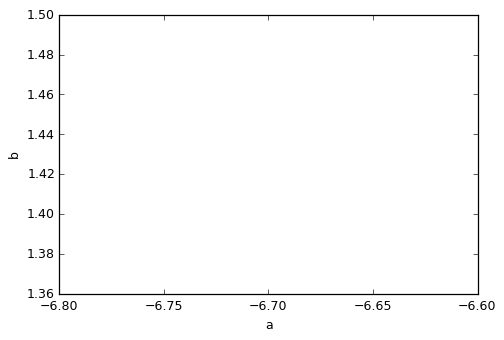

In [16]:
plt.xlim(-6.8, -6.6)
plt.ylim(1.36, 1.5)
plt.xlabel('a')
plt.ylabel('b')
plt.scatter(pboot0[2], pboot0[0], s=0.2)

# plot bootstrap distribution
mean = [np.mean(pboot0[2]), np.mean(pboot0[0])]
da = sigma1 = np.std(pboot0[2])
db = sigma2 = np.std(pboot0[0])

print 'Boot: a = %.4f +- %.4f  b = %.4f +- %.4f  sig = %.4f +- %.4f' %\
  (np.mean(pboot0[2]), np.std(pboot0[2]), np.mean(pboot0[0]), np.std(pboot0[0]),\
   np.mean(pboot0[1]), np.std(pboot0[1]))
    
for Nsig in (1, 2, 3):    
    plt.gca().add_patch(\
    Ellipse(mean, Nsig*sigma1, Nsig*sigma2, angle=0, ec='b', fc='none'))

# Hogg's method
mean, sigma1, sigma2, alpha = fit_bivariate_normal(pboot0[2], pboot0[0], robust=False)

da = abs(sigma1*np.cos(alpha) + sigma2*np.sin(alpha))
db = abs(sigma1*np.sin(alpha) + sigma2*np.cos(alpha))

print 'x0 = %.3f  a = %.4f +- %.4f  b = %.4f +- %.4f' % (x0, mean[0], da, mean[1], db)

for Nsig in (1, 2, 3):
    plt.gca().add_patch(\
    Ellipse(mean, Nsig*sigma1, Nsig*sigma2, angle=alpha*180./np.pi, ec='r', fc='none'))

There is still some residual correlation of $a$ and $b$.  It can be minimized by a more sophisticated choice of the offset $x_0$.

Now let's plot the new fit and check that it still fits the original data. 

C:\Users\Adam2\Anaconda\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in sqrt


x0 = 10.247  a = 7.9424 +- 0.0586  b = 0.0052 +- 0.0004  sig2 = -0.9720 +- 0.8898


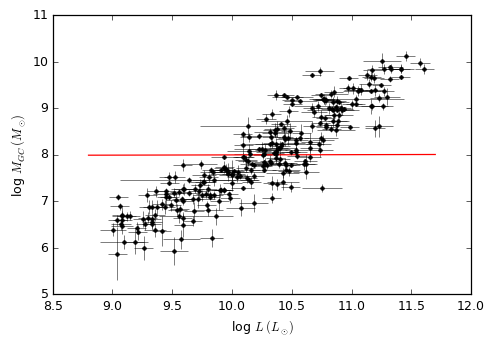

In [18]:
o = optimize.minimize(lnLikelihood0, [1.,1.], args=(x, y, dx, dy, x0))

a = intercept0(o.x, x, y, dx, dy, x0)
b = o.x[0]
sig2 = o.x[1]
sig = np.sqrt(sig2)
dsig = np.std(pboot0[1])

print 'x0 = %.3f  a = %.4f +- %.4f  b = %.4f +- %.4f  sig2 = %.4f +- %.4f' %\
  (x0, a-b*x0, da, b, db, sig2, dsig)

xa = np.array([8.8, 11.7])
plt.plot(xa, a+b*(xa-x0), 'r-')

plt.errorbar(x, y, xerr=dx, yerr=dy, fmt='.k', elinewidth=0.4, capsize=0)
plt.xlabel(r'log $L \ (L_\odot)$')
plt.ylabel(r'log $M_{GC} \ (M_\odot)$')
plt.show()

Let's plot the best model with the parameter errors:

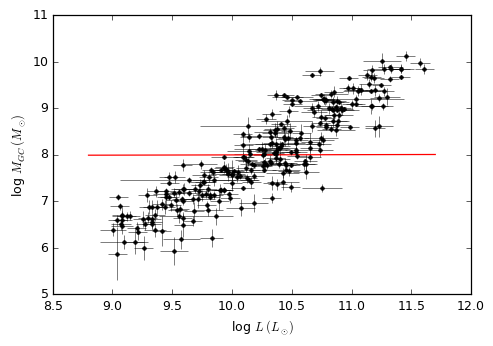

In [19]:
xa1 = np.array([8.8, x0])
plt.plot(xa1, a+b*(xa1-x0), 'r-')
plt.plot(xa1, a+(da+sig)+(b-db)*(xa1-x0), 'b-')
plt.plot(xa1, a-(da+sig)+(b+db)*(xa1-x0), 'b-')

xa2 = np.array([x0, 11.7])
plt.plot(xa2, a+b*(xa2-x0), 'r-')
plt.plot(xa2, a+(da+sig)+(b+db)*(xa2-x0), 'b-')
plt.plot(xa2, a-(da+sig)+(b-db)*(xa2-x0), 'b-')

plt.errorbar(x, y, xerr=dx, yerr=dy, fmt='.k', elinewidth=0.4, capsize=0)
plt.xlabel(r'log $L \ (L_\odot)$')
plt.ylabel(r'log $M_{GC} \ (M_\odot)$')
plt.show()

<b>Exercise:</b> Write a function that calculates bootstrapped estimate of $da$, with $x_0$ as an input argument. Find $x_0$ that minimizes $da$. Check the residual correlation of $a$ and $b$, and plot results.

### Forward fitting vs. Backward fitting

So far we have treated $x$ as an independent variable and $y$ as dependent variable, because we minimized the differences of $y_i$ from the model.  What if both variables are measured independently and we want to find the relation between them?  Do we get the same model if we fit $x$ vs. $y$?  For simplicity let's do it without the offsets.

$x = c + d \, y + \epsilon$

What are the expected values of $c$ and $d$ from our original fit parameters, $a$ and $b$?

In Homework 5 you evaluate the backward fit and compare it with the expected parameter values.

### Drawing from a distribution

It is often useful to be able to generate a simulated random sample drawn from a specified distribution.  This distribution may be analytical or discrete, such as an existing data sample.  A simulated sample can be used for comparison with data, in a technique called <i>parametric bootstrap</i>.

A general and very simple way to generate a simulated sample is the <b>transformation method</b>, described in $\S$7.3.2 of <a href="http://www.nr.com">Numerical Recipes</a> or $\S$3.7 of <a href="http://www.astroml.org/">Machine Learning</a>.  

<a href="http://www.astroml.org/book_figures/chapter3/fig_clone_distribution.html">Figure 3.25</a> provides a good illustration.

The example below shows how to clone a discrete sample.

KS test: D = 0.027; p = 1


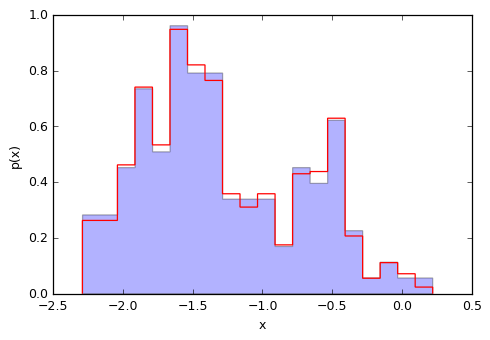

In [24]:
feh = np.loadtxt("gc.dat", usecols=(0,), unpack=True)

x = np.copy(feh)
x.sort()
Px = np.linspace(0, 1, len(x))

pspline = interpolate.UnivariateSpline(Px, x, s=0)

Nsample = 1000
Px_sample = np.linspace(0, 1, Nsample)
x_sample = pspline(Px_sample)

D, p = stats.ks_2samp(x, x_sample)
print "KS test: D = %.2g; p = %.2g" % (D, p)

plt.hist(x, bins=20, normed=True, histtype='stepfilled', alpha=0.3)
plt.hist(x_sample, bins=20, normed=True, histtype='step', color='r')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.show()

Now let's generate a normal distribution from the analytical DF, and compare it with the SciPy's implementation.

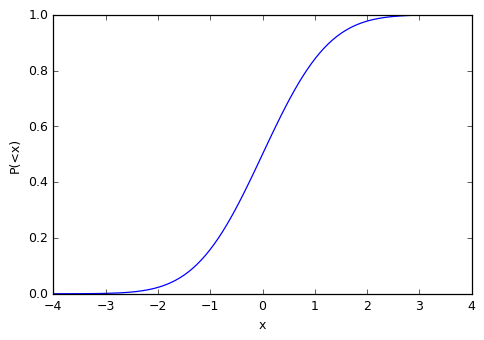

In [25]:
Nsample = 1000
mu = 0.
sig = 1.
x_norm = np.random.normal(mu, sig, Nsample)

x = np.linspace(mu-4*sig, mu+4*sig, 100)
Px = (1.+special.erf((x-mu)/sig/np.sqrt(2.)))/2.

plt.plot(x, Px)
plt.xlabel('x')
plt.ylabel('P(<x)')
plt.show()

KS test: D = 0.025; p = 0.91


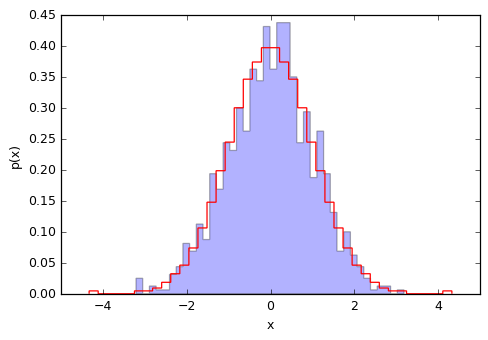

In [26]:
pspline = interpolate.UnivariateSpline(Px, x, s=0)

Px_sample = np.linspace(0, 1, Nsample)
x_sample = pspline(Px_sample)

D, p = stats.ks_2samp(x_norm, x_sample)
print "KS test: D = %.2g; p = %.2g" % (D, p)

plt.hist(x_norm, bins=40, normed=True, histtype='stepfilled', alpha=0.3)
plt.hist(x_sample, bins=40, normed=True, histtype='step', color='r')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.show()

### Parametric bootstrap

The idea of parametric bootstrap is to test whether an observed data set is consistent with a specified distribution.  For example, is our sample of globular cluster metallicities consistent with a normal distribution?

To answer this question, we need to:
1. Find a best-fitting normal distribution (calculate mean and standard deviation)
2. Calculate a merit function (goodness of fit, for example, $\chi^2$)
3. Generate simulated samples corresponding to the best-fit model
4. Estimate probability of the observed statistic in point 2 occuring in the parametric bootstrap samples. 

<b>Exercise 3:</b> Write a parametric bootstrap test for the observed [Fe/H].

-1.29638297872 0.567804388595 1.0071942446


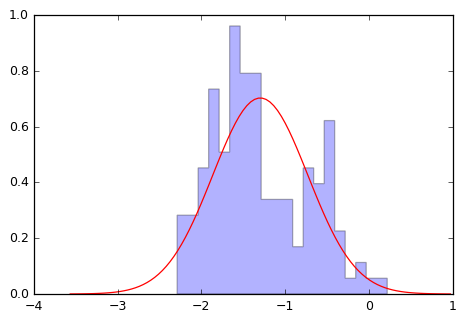

In [27]:
mu = np.mean(feh)
sig = np.std(feh, ddof=1)
chi2dof = np.sum(((feh-mu)/sig)**2)/(len(feh)-2)
print mu, sig, chi2dof

plt.hist(feh, bins=20, normed=True, histtype='stepfilled', alpha=0.3)

x = np.linspace(mu-4*sig, mu+4*sig, 100)
plt.plot(x, 1./(np.sqrt(2*np.pi)*sig)*np.exp(-((x-mu)/sig)**2/2), color='r')
plt.show()

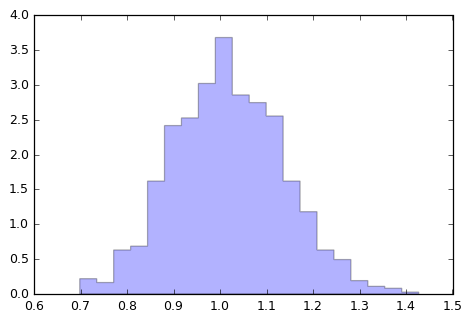

In [28]:
x = np.linspace(mu-4*sig, mu+4*sig, 100)
Px = (1.+special.erf((x-mu)/sig/np.sqrt(2.)))/2.
pspline = interpolate.UnivariateSpline(Px, x, s=0)

iboot = 0
chi2 = np.zeros(1000)
Nsample = len(feh)
while iboot < 1000:
    Px_sample = np.random.uniform(0, 1, Nsample)
    x_sample = pspline(Px_sample)
    chi2[iboot] = np.sum(((x_sample-mu)/sig)**2)/(len(x_sample)-2)
    iboot += 1

plt.hist(chi2, bins=20, normed=True, histtype='stepfilled', alpha=0.3)
plt.show()

In [29]:
z = np.sort(abs(chi2 - np.mean(chi2)))
zobs = abs(chi2dof - np.mean(chi2))
z_greaterthanobs = (z > zobs)
print np.sum(z_greaterthanobs)*1./len(z)

0.928
